James Fisher
ANA500
6-2-2024

Micro-Projects 1, 2, 3, & 4

Data Source: 2022 BRFSS

Target Variable: Difficulty Concentrating or Remembering (CIMEMLOS)

In [1]:
## Setup workspace

#import libraries
import os
import pandas as pd
import numpy as np

#set working directory
#os.chdir('/Users/jimmyfisher/Desktop/ANA500')

#import raw BRFSS data from XPT file
data = pd.read_sas('brfss2022.XPT')

Create df with variables of interest selected from data dictionary at https://www.cdc.gov/brfss/annual_data/2022/zip/codebook22_llcp-v2-508.zip using early childhood trauma variables and the following publication as a guide:

Casanova, R., Saldana, S., Lutz, M. W., Plassman, B. L., Kuchibhatla, M., & Hayden, K. M. (2020). Investigating predictors of cognitive decline using machine learning. The Journals of Gerontology: Series B, 75(4), 733-742.

In [10]:
#create df with target variable and subset df with features of interest
df = data[['CIMEMLOS', '_AGEG5YR', '_RACE1','_SEX', '_PHYS14D', '_MENT14D', '_BMI5', 'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 
           'MARITAL', 'EDUCA', 'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN', 'ACEDIVRC', 
           'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'SDHISOLT']]

#filter out survey respondents with no record of having been asked survey question about 
#memory loss or confusion (variable CIMEMLOS), because that is my output variable of interest
#and was only collected for adults >=45 years of age. 
df = df[df['_AGEG5YR'] >= 6]
df = df.dropna(subset=['CIMEMLOS'])
df = df.reset_index(drop=True)

#print columns of df
print("Columns:\n",df.columns)

#show first 5 rows of DF
print("Head:\n",df.head(5))

Columns:
 Index(['CIMEMLOS', '_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       '_BMI5', 'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX', 'SDHISOLT'],
      dtype='object')
Head:
    CIMEMLOS  _AGEG5YR  _RACE1  _SEX  _PHYS14D  _MENT14D   _BMI5  EXERANY2  \
0       1.0      12.0     1.0   1.0       1.0       1.0  1953.0       1.0   
1       2.0       9.0     1.0   2.0       1.0       1.0  3109.0       1.0   
2       1.0      12.0     1.0   1.0       2.0       9.0     NaN       1.0   
3       2.0      13.0     1.0   1.0       1.0       1.0  2439.0       1.0   
4       2.0      10.0     1.0   1.0       2.0       2.0  3228.0       1.0   

   SLEPTIM1  ADDEPEV3  ...  CVDCRHD4  ACEPRISN  ACEDIVRC  ACEPUNCH  ACEHURT1  \
0       8.0       2.0  ...       2.0       2.0       2.0       1.0       1.0   
1   

In [3]:
print(df.shape)

#create correction matrix to identify potential predictors
corr = df.corr()
print(corr)

(64675, 26)
          CIMEMLOS  _AGEG5YR    _RACE1      _SEX  _PHYS14D  _MENT14D  \
CIMEMLOS  1.000000  0.007883  0.013060  0.003213 -0.017363 -0.020786   
_AGEG5YR  0.007883  1.000000 -0.053368  0.025969  0.046075 -0.054490   
_RACE1    0.013060 -0.053368  1.000000 -0.028929  0.052490  0.051368   
_SEX      0.003213  0.025969 -0.028929  1.000000  0.034899  0.060957   
_PHYS14D -0.017363  0.046075  0.052490  0.034899  1.000000  0.293215   
_MENT14D -0.020786 -0.054490  0.051368  0.060957  0.293215  1.000000   
_BMI5    -0.017894 -0.152350  0.023943 -0.032839  0.071891  0.049047   
EXERANY2 -0.005840  0.065315  0.039646  0.038601  0.157656  0.094186   
SLEPTIM1  0.020578  0.077440  0.035156  0.020167  0.085983  0.073679   
ADDEPEV3  0.098926  0.091871  0.032017 -0.086584 -0.058684 -0.115179   
MARITAL   0.011457  0.074056  0.069319  0.061890  0.066808  0.076759   
EDUCA     0.037271 -0.021780 -0.083191 -0.002798 -0.106974 -0.069131   
VETERAN3  0.064167 -0.094075  0.055027  0.264753  0.

General observations on the above corr() output:

The above correlation matrix provides a slimpse into relationships between the dataset's variables. Most correlations are weak, indicating the lack of linear relationships between most variables. The strongest positive correlation observed is between PHYS14D and MENT14D (0.293), indicating a moderate positive linear relationship between reported levels of physical health and mental health. Another example of a meaningful correlation is the inverse relationship between SDHISOLT (social isolation) and MENT14D, suggesting that higher levels of social isolation are associated with worse mental health outcomes. Another observation of the above data is the cluster of correlations associated with adverse childhood experiences (ACEs), including ACEPRISN, ACEDIVRC, and ACEHVSEX, pointing to these experiences co-occurring in the same individuals. 

In [4]:
### Variable: CIMEMLOS (worsening confusion or memory loss)

#show pre-processing freqency distribution of variable values
print("pre-processing CIMEMLOS frequency:\n",df['CIMEMLOS'].value_counts())
print("\nNumber of NaN values in column: ",df['CIMEMLOS'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['CIMEMLOS'] = df['CIMEMLOS'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation
df['CIMEMLOS'] = df['CIMEMLOS'].replace(7,df['CIMEMLOS'].mode()[0])
df['CIMEMLOS'] = df['CIMEMLOS'].replace(9,df['CIMEMLOS'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing CIMEMLOS frequency:\n",df['CIMEMLOS'].value_counts())


pre-processing CIMEMLOS frequency:
 CIMEMLOS
2.0    56945
1.0     7003
7.0      474
9.0      253
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing CIMEMLOS frequency:
 CIMEMLOS
0.0    57672
1.0     7003
Name: count, dtype: int64


In [5]:
### Variable: _AGEG5YR (age categories)

#show pre-processing freqency distribution of variable values
print("pre-processing frequency:\n",df['_AGEG5YR'].value_counts())
print("\nNumber of NaN values in _AGEG5YR column: ",df['_AGEG5YR'].isna().sum(), "\n")

#recode 5-year age increments to begin at 1 (instead of 6, Age 45 to 49)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(6,1)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(7,2)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(8,3)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(9,4)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(10,5)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(11,6)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(12,7)
df['_AGEG5YR'] = df['_AGEG5YR'].replace(13,8)

#replace 14s (don't know / refused / missing) using mode imputation 
df['_AGEG5YR'] = df['_AGEG5YR'].replace(14,df['_AGEG5YR'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing _AGEG5YR frequency:\n",df['_AGEG5YR'].value_counts())

pre-processing frequency:
 _AGEG5YR
10.0    9952
11.0    9543
9.0     9279
13.0    7920
8.0     7429
12.0    7424
7.0     6682
6.0     5199
14.0    1247
Name: count, dtype: int64

Number of NaN values in _AGEG5YR column:  0 

post-processing _AGEG5YR frequency:
 _AGEG5YR
5.0    11199
6.0     9543
4.0     9279
8.0     7920
3.0     7429
7.0     7424
2.0     6682
1.0     5199
Name: count, dtype: int64


In [6]:
### Variable: _RACE1 (race/ethnicity categories)

#show pre-processing freqency distribution of variable values
print("pre-processing frequency:\n",df['_RACE1'].value_counts())
print("\nNumber of NaN values in _RACE1 column: ",df['_RACE1'].isna().sum(), "\n")

#replace 9s (don't know / not sure / refused) using mode imputation
df['_RACE1'] = df['_RACE1'].replace(9,df['_RACE1'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing _RACE1 frequency:\n",df['_RACE1'].value_counts())

pre-processing frequency:
 _RACE1
1.0    54291
2.0     4213
8.0     2335
9.0     1954
7.0      871
3.0      496
4.0      448
5.0       67
Name: count, dtype: int64

Number of NaN values in _RACE1 column:  0 

post-processing _RACE1 frequency:
 _RACE1
1.0    56245
2.0     4213
8.0     2335
7.0      871
3.0      496
4.0      448
5.0       67
Name: count, dtype: int64


In [7]:
### Variable: _SEX

#convert female(2) to female(0), leaving male(1)
df['_SEX'] = df['_SEX'].replace(2,0)

#show pre-processing freqency distribution of variable values
print("pre-processing frequency:\n",df['_SEX'].value_counts())
print("\nNumber of NaN values in _SEX column: ",df['_SEX'].isna().sum(), "\n")

    ## no processing required

pre-processing frequency:
 _SEX
0.0    35810
1.0    28865
Name: count, dtype: int64

Number of NaN values in _SEX column:  0 



In [8]:
### Variable: _PHYS14D (Three-level not good physical health status)

#show pre-processing freqency distribution of variable values
print("pre-processing frequency:\n",df['_PHYS14D'].value_counts())
print("\nNumber of NaN values in _PHYS14D column: ",df['_PHYS14D'].isna().sum(), "\n")

#replace 9s (don't know / refused / missing) using mode imputation
df['_PHYS14D'] = df['_PHYS14D'].replace(9,df['_PHYS14D'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing _PHYS14D frequency:\n",df['_PHYS14D'].value_counts())

pre-processing frequency:
 _PHYS14D
1.0    38344
2.0    14802
3.0     9755
9.0     1774
Name: count, dtype: int64

Number of NaN values in _PHYS14D column:  0 

post-processing _PHYS14D frequency:
 _PHYS14D
1.0    40118
2.0    14802
3.0     9755
Name: count, dtype: int64


In [9]:
### Variable: _MENT14D (Three-level not good mental health status)

#show pre-processing freqency distribution of variable values
print("pre-processing frequency:\n",df['_MENT14D'].value_counts())
print("\nNumber of NaN values in _MENT14D column: ",df['_MENT14D'].isna().sum(), "\n")

#replace 9s (don't know / refused / missing) using mode imputation
df['_MENT14D'] = df['_MENT14D'].replace(9,df['_MENT14D'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing _MENT14D frequency:\n",df['_MENT14D'].value_counts())

pre-processing frequency:
 _MENT14D
1.0    42980
2.0    13477
3.0     6897
9.0     1321
Name: count, dtype: int64

Number of NaN values in _MENT14D column:  0 

post-processing _MENT14D frequency:
 _MENT14D
1.0    44301
2.0    13477
3.0     6897
Name: count, dtype: int64


In [10]:
### Variable: _BMI5 (body mass index)

#show pre-processing variable distribution values
print("pre-processing data:\n")
print("Mean: ",df['_BMI5'].mean().round(2))
print("Median: ",df['_BMI5'].median())
print("Q1: ",df['_BMI5'].quantile(0.25))
print("Q3: ",df['_BMI5'].quantile(0.75))
print("\nNumber of NaN values in _BMI5 column: ",df['_BMI5'].isna().sum(), "\n")

#replace NaN rows with mean BMI values
df['_BMI5'] = df['_BMI5'].fillna(df['_BMI5'].mean())

#incorporate the 2 "implied decimal places" indicated by data dictionary and limit to 2 decimals
df['_BMI5'] = df['_BMI5']/100
df['_BMI5'] = df['_BMI5'].round(2)

#show post-processing variable distribution values
print("post-processing data:\n")
print("Mean: ",df['_BMI5'].mean().round(2))
print("Median: ",df['_BMI5'].median())
print("Q1: ",df['_BMI5'].quantile(0.25))
print("Q3: ",df['_BMI5'].quantile(0.75))
print("\nNumber of NaN values in _BMI5 column: ",df['_BMI5'].isna().sum(), "\n")

pre-processing data:

Mean:  2863.67
Median:  2746.0
Q1:  2437.0
Q3:  3174.0

Number of NaN values in _BMI5 column:  4285 

post-processing data:

Mean:  28.64
Median:  28.13
Q1:  24.56
Q3:  31.32

Number of NaN values in _BMI5 column:  0 



In [11]:
### Variable: EXERANY2 (past-month exercise)

#show pre-processing freqency distribution of variable values
print("pre-processing EXERANY2 frequency:\n",df['EXERANY2'].value_counts())
print("\nNumber of NaN values in column: ",df['EXERANY2'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['EXERANY2'] = df['EXERANY2'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation
df['EXERANY2'] = df['EXERANY2'].replace(7,df['EXERANY2'].mode()[0])
df['EXERANY2'] = df['EXERANY2'].replace(9,df['EXERANY2'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing EXERANY2 frequency:\n",df['EXERANY2'].value_counts())

pre-processing EXERANY2 frequency:
 EXERANY2
1.0    48021
2.0    16446
7.0      151
9.0       57
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing EXERANY2 frequency:
 EXERANY2
1.0    48229
0.0    16446
Name: count, dtype: int64


In [11]:
### Variable: SLEPTIM1 (average reported sleep per night)

#show pre-processing variable distribution values
print("pre-processing data:\n")
print("Mean: ",df['SLEPTIM1'].mean())
print("Median: ",df['SLEPTIM1'].median())
print("Q1: ",df['SLEPTIM1'].quantile(0.25))
print("Q3: ",df['SLEPTIM1'].quantile(0.75))
print("\nNumber of NaN values in SLEPTIM1 column: ",df['SLEPTIM1'].isna().sum(), "\n")
print("pre-processing SLEPTIM1 frequency:\n",df['SLEPTIM1'].value_counts())

#replace 77s (don't know / not sure) and 99s (refused to answer) using mean imputation to account for 
#missing data in records while minimizing impact on measures of central tendency for interval variable.
sleepMean = df['SLEPTIM1'][df['SLEPTIM1'] <77].mean()
df['SLEPTIM1'] = df['SLEPTIM1'].replace(77,sleepMean)
df['SLEPTIM1'] = df['SLEPTIM1'].replace(99,sleepMean)

#bin sleeptimes into 5 bins
df['SLEPTIM1'] = pd.cut(df['SLEPTIM1'], bins=5)

#show post-processing variable distribution values
print(df['SLEPTIM1'].value_counts())

pre-processing data:

Mean:  8.027398531117123
Median:  7.0
Q1:  6.0
Q3:  8.0

Number of NaN values in SLEPTIM1 column:  0 

pre-processing SLEPTIM1 frequency:
 SLEPTIM1
8.0     19346
7.0     19291
6.0     12881
5.0      3778
9.0      3527
10.0     1782
4.0      1670
77.0      738
12.0      459
3.0       434
2.0       214
1.0       124
11.0      105
99.0       77
16.0       57
14.0       52
15.0       49
13.0       29
18.0       25
20.0       20
24.0        9
19.0        3
23.0        2
22.0        2
17.0        1
Name: count, dtype: int64
SLEPTIM1
(5.6, 10.2]     57642
(0.977, 5.6]     6220
(10.2, 14.8]      645
(14.8, 19.4]      135
(19.4, 24.0]       33
Name: count, dtype: int64


In [13]:
### Variable: ADDEPEV3 (told had depressive disorder)

#show pre-processing freqency distribution of variable values
print("pre-processing ADDEPEV3 frequency:\n",df['ADDEPEV3'].value_counts())
print("\nNumber of NaN values in column: ",df['ADDEPEV3'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['ADDEPEV3'] = df['ADDEPEV3'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation
df['ADDEPEV3'] = df['ADDEPEV3'].replace(7,df['ADDEPEV3'].mode()[0])
df['ADDEPEV3'] = df['ADDEPEV3'].replace(9,df['ADDEPEV3'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing ADDEPEV3 frequency:\n",df['ADDEPEV3'].value_counts())

pre-processing ADDEPEV3 frequency:
 ADDEPEV3
2.0    51806
1.0    12531
7.0      245
9.0       93
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing ADDEPEV3 frequency:
 ADDEPEV3
0.0    52144
1.0    12531
Name: count, dtype: int64


In [14]:
### Variable: MARITAL (marital status)

#show pre-processing freqency distribution of variable values
print("pre-processing MARITAL frequency:\n",df['MARITAL'].value_counts())
print("\nNumber of NaN values in column: ",df['MARITAL'].isna().sum(), "\n")

#data recoded into 3-level variable: married(1), divorced/widowed(2), or other(3)
df['MARITAL'] = df['MARITAL'].replace(3,2)
df['MARITAL'] = df['MARITAL'].replace(4,3)
df['MARITAL'] = df['MARITAL'].replace(5,3)
df['MARITAL'] = df['MARITAL'].replace(6,3)
df['MARITAL'] = df['MARITAL'].replace(9,3)

#show post-processing freqency distribution of variable values
print("post-processing MARITAL frequency:\n",df['MARITAL'].value_counts())

pre-processing MARITAL frequency:
 MARITAL
1.0    36519
3.0    10259
2.0    10200
5.0     4836
6.0     1376
4.0      958
9.0      527
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing MARITAL frequency:
 MARITAL
1.0    36519
2.0    20459
3.0     7697
Name: count, dtype: int64


In [15]:
### Variable: EDUCA (educational attainment)

#show pre-processing freqency distribution of variable values
print("pre-processing EDUCA frequency:\n",df['EDUCA'].value_counts())
print("\nNumber of NaN values in column: ",df['EDUCA'].isna().sum(), "\n")

#data recoded into 3-level variable: no high school diploma(0), only high school diploma/GED (1),  
#  and at least one 4-year college degree(2)
df['EDUCA'] = df['EDUCA'].replace(1,0)
df['EDUCA'] = df['EDUCA'].replace(2,0)
df['EDUCA'] = df['EDUCA'].replace(3,0)
df['EDUCA'] = df['EDUCA'].replace(4,1)
df['EDUCA'] = df['EDUCA'].replace(5,1)
df['EDUCA'] = df['EDUCA'].replace(6,2)

#replaced 9s (refused) using mode imputation
df['EDUCA'] = df['EDUCA'].replace(9,df['EDUCA'].mode()[0])

#show post-processing freqency distribution of variable values
print("post-processing EDUCA frequency:\n",df['EDUCA'].value_counts())
print("\nNumber of NaN values in column: ",df['EDUCA'].isna().sum(), "\n")

pre-processing EDUCA frequency:
 EDUCA
6.0    28066
5.0    17917
4.0    15299
3.0     2143
2.0      889
9.0      297
1.0       64
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing EDUCA frequency:
 EDUCA
1.0    33513
2.0    28066
0.0     3096
Name: count, dtype: int64

Number of NaN values in column:  0 



In [16]:
### Variable: VETERAN3 (served on active duty in the armed forces)

#show pre-processing freqency distribution of variable values
print("pre-processing VETERAN3 frequency:\n",df['VETERAN3'].value_counts())
print("\nNumber of NaN values in column: ",df['VETERAN3'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['VETERAN3'] = df['VETERAN3'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation
df['VETERAN3'] = df['VETERAN3'].replace(7,df['VETERAN3'].mode()[0])
df['VETERAN3'] = df['VETERAN3'].replace(9,df['VETERAN3'].mode()[0])

#show post-processing frequency distribution of variable values
print("post-processing VETERAN3 frequency:\n",df['VETERAN3'].value_counts())

pre-processing VETERAN3 frequency:
 VETERAN3
2.0    54442
1.0    10065
9.0      134
7.0       34
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing VETERAN3 frequency:
 VETERAN3
0.0    54610
1.0    10065
Name: count, dtype: int64


In [17]:
### Variable: INCOME3 (annual household income)

#show pre-processing freqency distribution of variable values
print("pre-processing INCOME3 frequency:\n",df['INCOME3'].value_counts())
print("\nNumber of NaN values in column: ",df['INCOME3'].isna().sum(), "\n")

#left 77s (don't know / not sure) and 99s (refused) alone to assess later due to possible predictive power (using dummy variables)
    
#replaced single missing record with mode imputation
df['INCOME3'] = df['INCOME3'].fillna(7)

#show post-processing freqency distribution of variable values
print("post-processing INCOME3 frequency:\n",df['INCOME3'].value_counts())

pre-processing INCOME3 frequency:
 INCOME3
7.0     9199
99.0    8225
8.0     7436
6.0     7299
9.0     7219
5.0     6556
77.0    4697
4.0     3084
10.0    3019
11.0    2884
3.0     2224
2.0     1730
1.0     1102
Name: count, dtype: int64

Number of NaN values in column:  1 

post-processing INCOME3 frequency:
 INCOME3
7.0     9200
99.0    8225
8.0     7436
6.0     7299
9.0     7219
5.0     6556
77.0    4697
4.0     3084
10.0    3019
11.0    2884
3.0     2224
2.0     1730
1.0     1102
Name: count, dtype: int64


In [18]:
### Variable: CVDSTRK3 (had stroke)

#show pre-processing freqency distribution of variable values
print("pre-processing CVDSTRK3 frequency:\n",df['CVDSTRK3'].value_counts())
print("\nNumber of NaN values in column: ",df['CVDSTRK3'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['CVDSTRK3'] = df['CVDSTRK3'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation (replaced with NO)
df['CVDSTRK3'] = df['CVDSTRK3'].replace(7,df['CVDSTRK3'].mode()[0])
df['CVDSTRK3'] = df['CVDSTRK3'].replace(9,df['CVDSTRK3'].mode()[0])

#show post-processing freqency distribution of variable values
print("post-processing CVDSTRK3 frequency:\n",df['CVDSTRK3'].value_counts())

pre-processing CVDSTRK3 frequency:
 CVDSTRK3
2.0    60575
1.0     3863
7.0      205
9.0       32
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing CVDSTRK3 frequency:
 CVDSTRK3
0.0    60812
1.0     3863
Name: count, dtype: int64


In [19]:
### Variable: CVDINFR4 (had heart attack)

#show pre-processing freqency distribution of variable values
print("pre-processing CVDINFR4 frequency:\n",df['CVDINFR4'].value_counts())
print("\nNumber of NaN values in column: ",df['CVDINFR4'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['CVDINFR4'] = df['CVDINFR4'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation (replaced with NO)
df['CVDINFR4'] = df['CVDINFR4'].replace(7,df['CVDINFR4'].mode()[0])
df['CVDINFR4'] = df['CVDINFR4'].replace(9,df['CVDINFR4'].mode()[0])

#show post-processing freqency distribution of variable values
print("post-processing CVDINFR4 frequency:\n",df['CVDINFR4'].value_counts())

pre-processing CVDINFR4 frequency:
 CVDINFR4
2.0    59103
1.0     5107
7.0      420
9.0       45
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing CVDINFR4 frequency:
 CVDINFR4
0.0    59568
1.0     5107
Name: count, dtype: int64


In [20]:
### Variable: CVDCRHD4 (had angina or coronary heart disease)

#show pre-processing freqency distribution of variable values
print("pre-processing CVDCRHD4 frequency:\n",df['CVDCRHD4'].value_counts())
print("\nNumber of NaN values in column: ",df['CVDCRHD4'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['CVDCRHD4'] = df['CVDCRHD4'].replace(2,0)

#replace 7s (don't know / not sure) and 9s (refused to answer) using mode imputation (replaced with NO)
df['CVDCRHD4'] = df['CVDCRHD4'].replace(7,df['CVDCRHD4'].mode()[0])
df['CVDCRHD4'] = df['CVDCRHD4'].replace(9,df['CVDCRHD4'].mode()[0])

#show post-processing freqency distribution of variable values
print("post-processing CVDCRHD4 frequency:\n",df['CVDCRHD4'].value_counts())

pre-processing CVDCRHD4 frequency:
 CVDCRHD4
2.0    58326
1.0     5547
7.0      751
9.0       51
Name: count, dtype: int64

Number of NaN values in column:  0 

post-processing CVDCRHD4 frequency:
 CVDCRHD4
0.0    59128
1.0     5547
Name: count, dtype: int64


In [21]:
### Variable: ACEPRISN (lived as child with some who served prison/jail time)

#show pre-processing freqency distribution of variable values
print("pre-processing ACEPRISN frequency:\n",df['ACEPRISN'].value_counts())
print("\nNumber of NaN values in column: ",df['ACEPRISN'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['ACEPRISN'] = df['ACEPRISN'].replace(2,0)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure) and 9s (refused) were merely recoded for now as a third "refused/unknown" category (2).
df['ACEPRISN'] = df['ACEPRISN'].replace(7,2)
df['ACEPRISN'] = df['ACEPRISN'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACEPRISN frequency:\n",df['ACEPRISN'].value_counts())

pre-processing ACEPRISN frequency:
 ACEPRISN
2.0    17770
1.0      915
9.0      215
7.0       56
Name: count, dtype: int64

Number of NaN values in column:  45719 

post-processing ACEPRISN frequency:
 ACEPRISN
0.0    17770
1.0      915
2.0      271
Name: count, dtype: int64


In [22]:
### Variable: ACEDIVRC (parents divorced or separated when respondent was a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACEDIVRC frequency:\n",df['ACEDIVRC'].value_counts())
print("\nNumber of NaN values in column: ",df['ACEDIVRC'].isna().sum(), "\n")

#convert categorical variable to a binary variable change '2' (no) to 0
df['ACEDIVRC'] = df['ACEDIVRC'].replace(2,0)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), 8s (parents not married) and 9s (refused) were merely recoded for now as a third 
#"refused/unknown/other" category (2).
df['ACEDIVRC'] = df['ACEDIVRC'].replace(7,2)
df['ACEDIVRC'] = df['ACEDIVRC'].replace(8,2)
df['ACEDIVRC'] = df['ACEDIVRC'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACEDIVRC frequency:\n",df['ACEDIVRC'].value_counts())

pre-processing ACEDIVRC frequency:
 ACEDIVRC
2.0    13937
1.0     4467
9.0      236
8.0      184
7.0      121
Name: count, dtype: int64

Number of NaN values in column:  45730 

post-processing ACEDIVRC frequency:
 ACEDIVRC
0.0    13937
1.0     4467
2.0      541
Name: count, dtype: int64


In [23]:
### Variable: ACEPUNCH (parents/adults in home beat each other when respondent was a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACEPUNCH frequency:\n",df['ACEPUNCH'].value_counts())
print("\nNumber of NaN values in column: ",df['ACEPUNCH'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACEPUNCH'] = df['ACEPUNCH'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACEPUNCH'] = df['ACEPUNCH'].replace(2,1)
df['ACEPUNCH'] = df['ACEPUNCH'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACEPUNCH'] = df['ACEPUNCH'].replace(7,2)
df['ACEPUNCH'] = df['ACEPUNCH'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACEPUNCH frequency:\n",df['ACEPUNCH'].value_counts())

pre-processing ACEPUNCH frequency:
 ACEPUNCH
1.0    15432
3.0     2213
2.0      675
9.0      315
7.0      292
Name: count, dtype: int64

Number of NaN values in column:  45748 

post-processing ACEPUNCH frequency:
 ACEPUNCH
0.0    15432
1.0     2888
2.0      607
Name: count, dtype: int64


In [24]:
### Variable: ACEHURT1 (parents/adults in home beat respondent as a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACEHURT1 frequency:\n",df['ACEHURT1'].value_counts())
print("\nNumber of NaN values in column: ",df['ACEHURT1'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACEHURT1'] = df['ACEHURT1'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACEHURT1'] = df['ACEHURT1'].replace(2,1)
df['ACEHURT1'] = df['ACEHURT1'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACEHURT1'] = df['ACEHURT1'].replace(7,2)
df['ACEHURT1'] = df['ACEHURT1'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACEHURT1 frequency:\n",df['ACEHURT1'].value_counts())

pre-processing ACEHURT1 frequency:
 ACEHURT1
1.0    13727
3.0     3546
2.0     1149
9.0      336
7.0      143
Name: count, dtype: int64

Number of NaN values in column:  45774 

post-processing ACEHURT1 frequency:
 ACEHURT1
0.0    13727
1.0     4695
2.0      479
Name: count, dtype: int64


In [25]:
### Variable: ACESWEAR (parents/adults in home swore at and insulted respondent as a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACESWEAR frequency:\n",df['ACESWEAR'].value_counts())
print("\nNumber of NaN values in column: ",df['ACESWEAR'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACESWEAR'] = df['ACESWEAR'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACESWEAR'] = df['ACESWEAR'].replace(2,1)
df['ACESWEAR'] = df['ACESWEAR'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACESWEAR'] = df['ACESWEAR'].replace(7,2)
df['ACESWEAR'] = df['ACESWEAR'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACESWEAR frequency:\n",df['ACESWEAR'].value_counts())

pre-processing ACESWEAR frequency:
 ACESWEAR
1.0    12475
3.0     5021
2.0      792
9.0      337
7.0      257
Name: count, dtype: int64

Number of NaN values in column:  45793 

post-processing ACESWEAR frequency:
 ACESWEAR
0.0    12475
1.0     5813
2.0      594
Name: count, dtype: int64


In [26]:
### Variable: ACETOUCH (respondent molested by a person 5+ years older or an adult while a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACETOUCH frequency:\n",df['ACETOUCH'].value_counts())
print("\nNumber of NaN values in column: ",df['ACETOUCH'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACETOUCH'] = df['ACETOUCH'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACETOUCH'] = df['ACETOUCH'].replace(2,1)
df['ACETOUCH'] = df['ACETOUCH'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACETOUCH'] = df['ACETOUCH'].replace(7,2)
df['ACETOUCH'] = df['ACETOUCH'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACETOUCH frequency:\n",df['ACETOUCH'].value_counts())

pre-processing ACETOUCH frequency:
 ACETOUCH
1.0    16068
3.0     1513
2.0      808
9.0      388
7.0       75
Name: count, dtype: int64

Number of NaN values in column:  45823 

post-processing ACETOUCH frequency:
 ACETOUCH
0.0    16068
1.0     2321
2.0      463
Name: count, dtype: int64


In [27]:
### Variable: ACETTHEM (person 5+ years older or an adult tried to make respondent touch them sexually while a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACETTHEM frequency:\n",df['ACETTHEM'].value_counts())
print("\nNumber of NaN values in column: ",df['ACETTHEM'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACETTHEM'] = df['ACETTHEM'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACETTHEM'] = df['ACETTHEM'].replace(2,1)
df['ACETTHEM'] = df['ACETTHEM'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACETTHEM'] = df['ACETTHEM'].replace(7,2)
df['ACETTHEM'] = df['ACETTHEM'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACETTHEM frequency:\n",df['ACETTHEM'].value_counts())

pre-processing ACETTHEM frequency:
 ACETTHEM
1.0    16732
3.0     1066
2.0      583
9.0      363
7.0       86
Name: count, dtype: int64

Number of NaN values in column:  45845 

post-processing ACETTHEM frequency:
 ACETTHEM
0.0    16732
1.0     1649
2.0      449
Name: count, dtype: int64


In [28]:
### Variable: ACEHVSEX (person 5+ years older or an adult tried to force respondent to have sex while a child)

#show pre-processing freqency distribution of variable values
print("pre-processing ACEHVSEX frequency:\n",df['ACEHVSEX'].value_counts())
print("\nNumber of NaN values in column: ",df['ACEHVSEX'].isna().sum(), "\n")

#recode never(1) to no(0)
df['ACEHVSEX'] = df['ACEHVSEX'].replace(1,0)

#recode once(2) and "more than once"(3) to yes(1)
df['ACEHVSEX'] = df['ACEHVSEX'].replace(2,1)
df['ACEHVSEX'] = df['ACEHVSEX'].replace(3,1)

#since most records lack responses to this question, variable was recoded to support a second
#analysis on the subset of records for which these data are available. As such, 7s (don't know /
#not sure), and 9s (refused) were merely recoded for now as a third 
#"refused/unknown" category (2).
df['ACEHVSEX'] = df['ACEHVSEX'].replace(7,2)
df['ACEHVSEX'] = df['ACEHVSEX'].replace(9,2)

#NaN values will be removed prior to this subcohort analysis.

#show post-processing freqency distribution of variable values
print("post-processing ACEHVSEX frequency:\n",df['ACEHVSEX'].value_counts())

pre-processing ACEHVSEX frequency:
 ACEHVSEX
1.0    17400
3.0      637
9.0      368
2.0      302
7.0       86
Name: count, dtype: int64

Number of NaN values in column:  45882 

post-processing ACEHVSEX frequency:
 ACEHVSEX
0.0    17400
1.0      939
2.0      454
Name: count, dtype: int64


In [29]:
### Variable: SDHISOLT (feelings of social isolation)

#show pre-processing freqency distribution of variable values
print("pre-processing SDHISOLT frequency:\n",df['SDHISOLT'].value_counts())
print("\nNumber of NaN values in column: ",df['SDHISOLT'].isna().sum(), "\n")

#replace NaN rows with mode of distribution
df['SDHISOLT'] = df['SDHISOLT'].fillna(df['SDHISOLT'].mode())

#replace NaN's, 7s (don't know / not sure) and 9s (refused to answer) using mode imputation
df['SDHISOLT'] = df['SDHISOLT'].fillna(df['SDHISOLT'].mode()[0])
df['SDHISOLT'] = df['SDHISOLT'].replace(7,df['SDHISOLT'].mode()[0]) #replaces with NO
df['SDHISOLT'] = df['SDHISOLT'].replace(9,df['SDHISOLT'].mode()[0])

#show post-processing freqency distribution of variable values
print("post-processing SDHISOLT frequency:\n",df['SDHISOLT'].value_counts())
print("\nNumber of NaN values in column: ",df['SDHISOLT'].isna().sum(), "\n")

pre-processing SDHISOLT frequency:
 SDHISOLT
5.0    25264
4.0    14122
3.0     9907
2.0     2063
1.0     1439
7.0      390
9.0      191
Name: count, dtype: int64

Number of NaN values in column:  11299 

post-processing SDHISOLT frequency:
 SDHISOLT
5.0    37144
4.0    14122
3.0     9907
2.0     2063
1.0     1439
Name: count, dtype: int64

Number of NaN values in column:  0 



In [30]:
#export df to csv
df.to_csv('brfss2022_clean.csv', index=False)

In [31]:
print('Booyah!')

Booyah!


//**--MICRO PROJECT 2, ANA 500, WEEK 2--**\\

In [19]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load data from Micro Project 1
df = pd.read_csv("brfss2022_clean.csv")

#check data load
df.head()

,CIMEMLOS,_AGEG5YR,_RACE1,_SEX,_PHYS14D,_MENT14D,_BMI5,EXERANY2,SLEPTIM1,ADDEPEV3,...,CVDCRHD4,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT1,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,SDHISOLT
0,1.0,7.0,1.0,1.0,1.0,1.0,19.53,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0.0,4.0,1.0,0.0,1.0,1.0,31.09,1.0,6.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0
2,1.0,7.0,1.0,1.0,2.0,1.0,28.64,1.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
3,0.0,8.0,1.0,1.0,1.0,1.0,24.39,1.0,8.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0
4,0.0,5.0,1.0,1.0,2.0,2.0,32.28,1.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


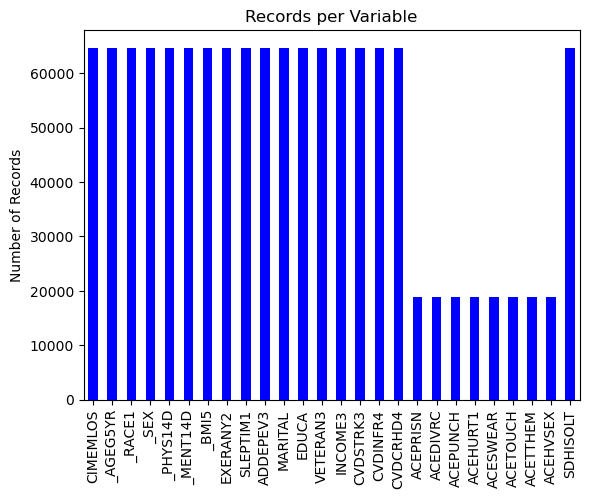

In [33]:
## Visualize records per variable
df.count().plot(kind='bar', color='blue')  # Ensure uniform color and no annotations
plt.title('Records per Variable')
plt.ylabel('Number of Records')
plt.show()

As indicated during data preprocessing, adverse childhood experience (ACE) variable data were only available for a subset of our total records. 

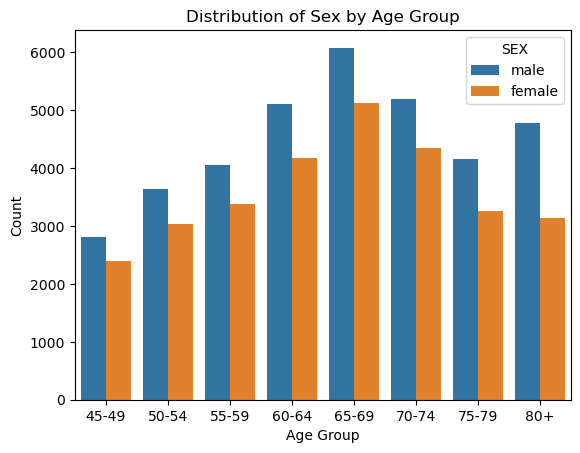

In [34]:
#create a bar chart of the distribution of _SEX by _AGEG5YR
sns.countplot(data=df, x='_AGEG5YR', hue='_SEX')

#modify the legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['male' if label == '0.0' else 'female' for label in labels]

#add labels
plt.title('Distribution of Sex by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')

#create array of age group labels
age_labels = ['45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
plt.xticks(ticks=range(len(age_labels)), labels=age_labels)

plt.legend(handles, new_labels, title='SEX')
plt.show()

A large quantity of respondents across all age groups are included in the data. However, the distribution is roughly normal with a slight left skew, and 65-69 year old respondents are disproportionately represented.

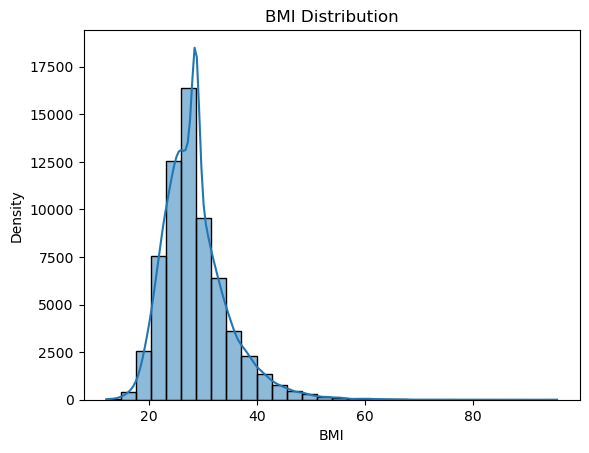

In [35]:
#create a histogram of the _BMI5 variable with overlaid density plot
sns.histplot(df['_BMI5'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.show()

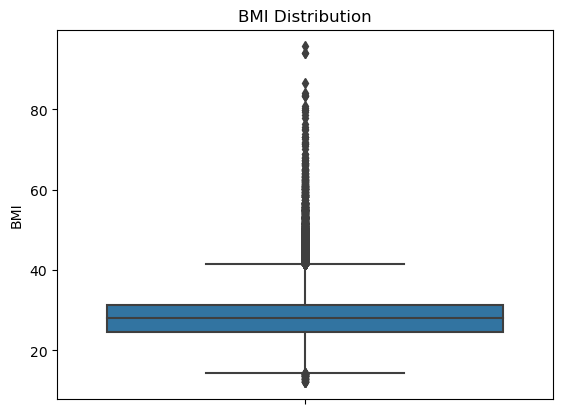

In [36]:
#create a boxplot of the _BMI5 variable
sns.boxplot(data=df, y='_BMI5')
plt.title('BMI Distribution')
plt.ylabel('BMI')
plt.show()

The distribution of BMI data is bell-shaped and centered around 20-30 BMI. This suggests that most data points fall within this range, typical of a normal distribution except with some right skewness towards higher BMI values. The boxplot confirms this, showing several outliers at the top end of the distribution. 

**This variable is not directly relevant to my research question, and is included here only to show outputs relevant to a continuous variable.

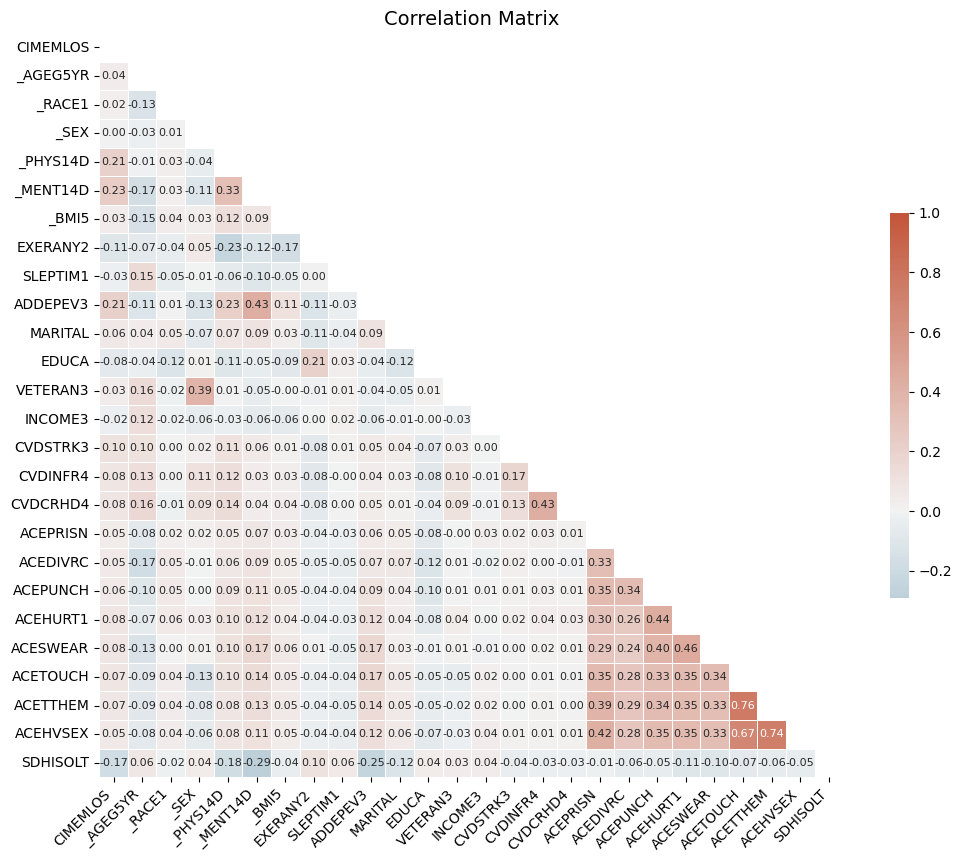

In [37]:
#create correlation matrix (all numeric columns)
corr = df.corr()

#hide (redundant) upper triangle of matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

#create matplotlib figure
plt.figure(figsize=(12, 10))  # You can adjust the size depending on your preference
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size": 8})

#rotate x-axis labels and adjust font size
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

#create title
plt.title('Correlation Matrix', fontsize=14)

plt.show()

This visualization makes it much easier to identify pairwise linear correlations between the variables in my prepared dataset, with intensity of the color red indicating strength of positive linear relationships and of blue the strength of negative/inverse linear relationships. 

The matrix reveals moderate correlations, such as between bad mental health days (_MENT14D) and social isolation (SDHISOLT), with a positive linear coefficient of 0.29. Variables such as history of heart attack (CVDINFR4) are also somewhat correlated with history of stroke (CVDSTRK3, 0.13) and heart disease (CVDCRHD4, 0.43). Finally, the red color cluster at the lower-right pertaining to adverse childhood experiences indicates collinearity across that variable subset.

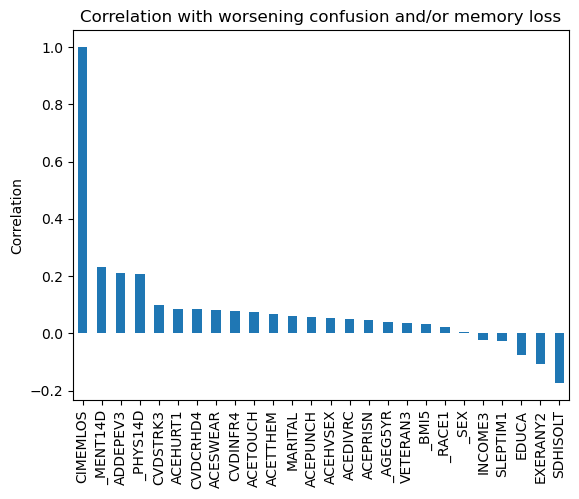

In [38]:
#recompute correlation matrix for CIMEMLOS on the x-axis
corr = df.corrwith(df['CIMEMLOS'])

#sort linear correlation coefficients in descending order
corr_sorted = corr.sort_values(ascending=False)

#create a bar plot of the correlations
corr_sorted.plot(kind='bar')

plt.title('Correlation with worsening confusion and/or memory loss')
plt.ylabel('Correlation')
plt.show()

This barchart shows the correlation coefficients of each variable in the dataset with respect to the primary target variable of this analysis, worsening memory loss and/or confusion (CIMEMLOS). Over on the left is the variable CIMEMLOS itself, after which, from left to right, are descending correlation coefficients to SDHISOLT (social isolation) at a correlation coefficient of about -0.175.

While this visualization does not itself indicate statistical significance, this is a step in understanding general patterns of linear correlation in our data.

To consider the subset of these data specifically relevant to my research question, a subcohort of these data was created.

RESEARCH QUESTION:
Is self-reported worsening confusion or memory loss in adults age 45 and older (CIMEMLOS) predicted by age (_AGEG5YR), sex (_SEX), race/ethnicity (_RACE1), chronic disease (ADDEPEV3, _MENT14D, _PHYS14D, CVDCRHD4), or traumatic childhood events (ACESWEAR, ACETOUCH, ACETTHEM, ACEHVSEX)?

In [20]:
#create df2 as research question dataframe with variables of interest
df2 = df[['CIMEMLOS', 'ADDEPEV3', '_AGEG5YR', '_SEX', '_RACE1', '_MENT14D', '_PHYS14D', 'CVDCRHD4', 
          'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [21]:
#create dictionary mapping age group codes to labels
age_groups = {
    1: '45-49', 2: '50-54', 3: '55-59', 4: '60-64',
    5: '65-69', 6: '70-74', 7: '75-79', 8: '80+'
}

#replace numerical values in the '_AGEG5YR' column with map
df2.loc[:, '_AGEG5YR'] = df2['_AGEG5YR'].replace(age_groups)

In [22]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash

#initialize app
app = JupyterDash(__name__)

#define app layout
app.layout = html.Div([
    html.H1("Data Exploration App"),
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': i, 'value': i} for i in df2.columns if i not in ['CIMEMLOS', '_AGEG5YR']],
        value=df2.columns[2]
    ),
    dcc.Graph(id='correlation-graph'),
])

#handle graph callbacks on dropdown selection
@app.callback(
    Output('correlation-graph', 'figure'),
    [Input('variable-dropdown', 'value')]
)
def update_graph(selected_var):
    #calculate correlations for each age group
    correlations = []
    age_groups = df2['_AGEG5YR'].unique()
    for age in sorted(age_groups):
        subset = df2[df2['_AGEG5YR'] == age]
        corr_value = subset[['CIMEMLOS', selected_var]].corr().iloc[0, 1]
        correlations.append(corr_value)

    #create figure
    fig = px.bar(
        x=sorted(age_groups),
        y=correlations,
        labels={'x': '_AGEG5YR', 'y': 'Correlation'},
        title=f'Correlation between CIMEMLOS and {selected_var} by Age Group'
    )
    return fig

#run app inside Jupyter notebook
app.run_server(mode='inline')

C:\Users\unkno\AppData\Roaming\Python\Python311\site-packages\dash\dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File D:\anaconda\Lib\site-packages\pandas\core\frame.py:3767, in DataFrame.__getitem__(
    self=       CIMEMLOS  ADDEPEV3 _AGEG5YR  _SEX  _RACE1...N       NaN       NaN  

[5199 rows x 12 columns],
    key=['CIMEMLOS', None]
)
   3765     if is_iterator(key):
   3766         key = list(key)
-> 3767     indexer = self.columns._get_indexer_strict(key, "columns")[1]
        key = ['CIMEMLOS', None]
        self =        CIMEMLOS  ADDEPEV3 _AGEG5YR  _SEX  _RACE1  _MENT14D  _PHYS14D  \
6           0.0       0.0    45-49   0.0     8.0       2.0       2.0   
19          0.0       1.0    45-49   0.0     1.0       2.0       1.0   
108         1.0       0.0    45-49   0.0     1.0       1.0       3.0   
206         0.0       0.0    45-49   1.0     1.0       1.0       1.0   
479         0.0       0.0    45-49   0.0     1.0       2.0       1.0   
.

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File D:\anaconda\Lib\site-packages\pandas\core\frame.py:10054, in DataFrame.corr(
    self=       CIMEMLOS _AGEG5YR
6           0.0    45-4...64662       0.0    45-49

[5199 rows x 2 columns],
    method='pearson',
    min_periods=1,
    numeric_only=False
)
  10052 cols = data.columns
  10053 idx = cols.copy()
> 10054 mat = data.to_numpy(dtype=float, na_value=np.nan, copy=False)
        data =        CIMEMLOS _AGEG5YR
6           0.0    45-49
19          0.0    45-49
108         1.0    45-49
206         0.0    45-49
479         0.0    45-49
...         ...      ...
64618       0.0    45-49
64649       0.0    45-49
64653       0.0    45-49
64660       1.0    45-49
64662       0.0    45-49

[5199 rows x 2 columns]
        np.nan = nan
        np = <module 'numpy' from 'D:\\anaconda\\Lib\\site-packages\\numpy\\__init__.py'>
  10056 if met

Respondent age clearly mediates observed linear correlations between memory loss/confusion and included predictor variables. Looking at length through the above Dash app made it clear that predictor-based differences in memory loss and tended to decrease with age, particularly in the 75-79, and 80+ age groups. 

To explore data available for my adverse childhood experience (ACE) sub-cohort, I created a subset for separate consideration.

In [42]:
#create df2_subset by dropping all rows with missing values
df2_subset = df.dropna()

#show the shape of the subset
print(df2_subset.shape)

(18793, 26)


   CIMEMLOS  _AGEG5YR  _RACE1  _SEX  _PHYS14D  _MENT14D  _BMI5  EXERANY2  \
0       1.0       7.0     1.0   1.0       1.0       1.0  19.53       1.0   
1       0.0       4.0     1.0   0.0       1.0       1.0  31.09       1.0   
2       1.0       7.0     1.0   1.0       2.0       1.0  28.64       1.0   
3       0.0       8.0     1.0   1.0       1.0       1.0  24.39       1.0   
4       0.0       5.0     1.0   1.0       2.0       2.0  32.28       1.0   

   SLEPTIM1  ADDEPEV3  ...  CVDCRHD4  ACEPRISN  ACEDIVRC  ACEPUNCH  ACEHURT1  \
0       8.0       0.0  ...       0.0       0.0       0.0       0.0       0.0   
1       6.0       0.0  ...       0.0       0.0       1.0       1.0       1.0   
2       7.0       1.0  ...       0.0       0.0       0.0       0.0       0.0   
3       8.0       0.0  ...       0.0       0.0       0.0       1.0       1.0   
4       7.0       0.0  ...       1.0       0.0       0.0       0.0       0.0   

   ACESWEAR  ACETOUCH  ACETTHEM  ACEHVSEX  SDHISOLT  
0       

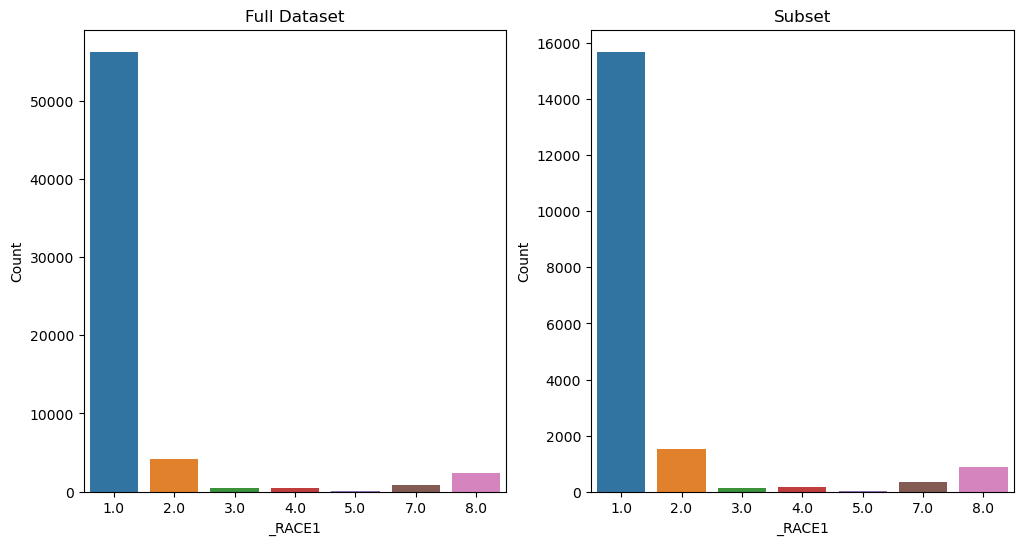

In [43]:
#show the head of the subset
print(df2_subset.head())

#compare the distribution of _RACE1 in the full dataset and the subset
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df2, x='_RACE1', ax=axs[0])
axs[0].set_title('Full Dataset')
axs[0].set_ylabel('Count')

sns.countplot(data=df2_subset, x='_RACE1', ax=axs[1])
axs[1].set_title('Subset')
axs[1].set_ylabel('Count')

plt.show()

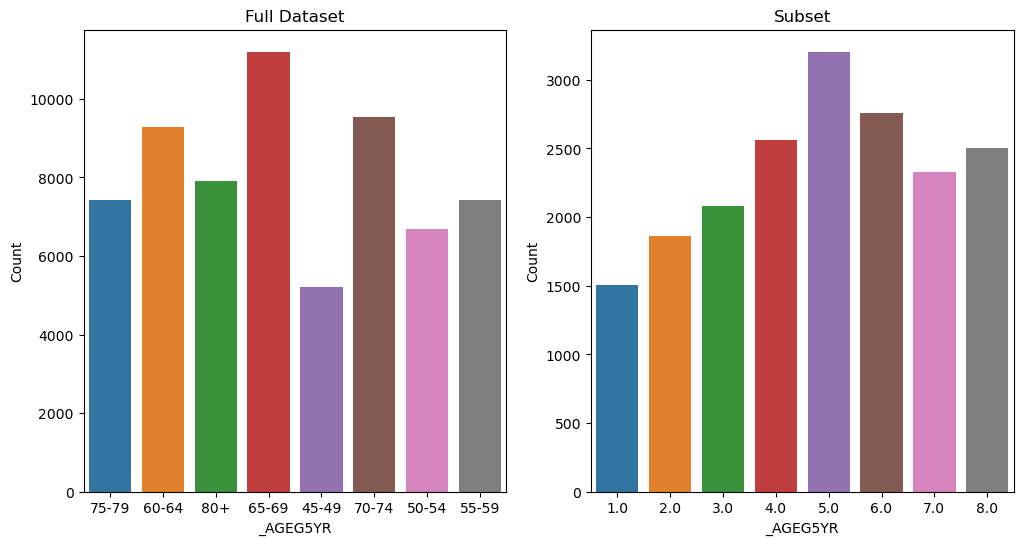

In [44]:
#compare the distribution of _AGEG5YR in the full dataset and the subset
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df2, x='_AGEG5YR', ax=axs[0])
axs[0].set_title('Full Dataset')
axs[0].set_ylabel('Count')

sns.countplot(data=df2_subset, x='_AGEG5YR', ax=axs[1])
axs[1].set_title('Subset')
axs[1].set_ylabel('Count')

plt.show()

[Text(0, 0, 'male'), Text(1, 0, 'female')]

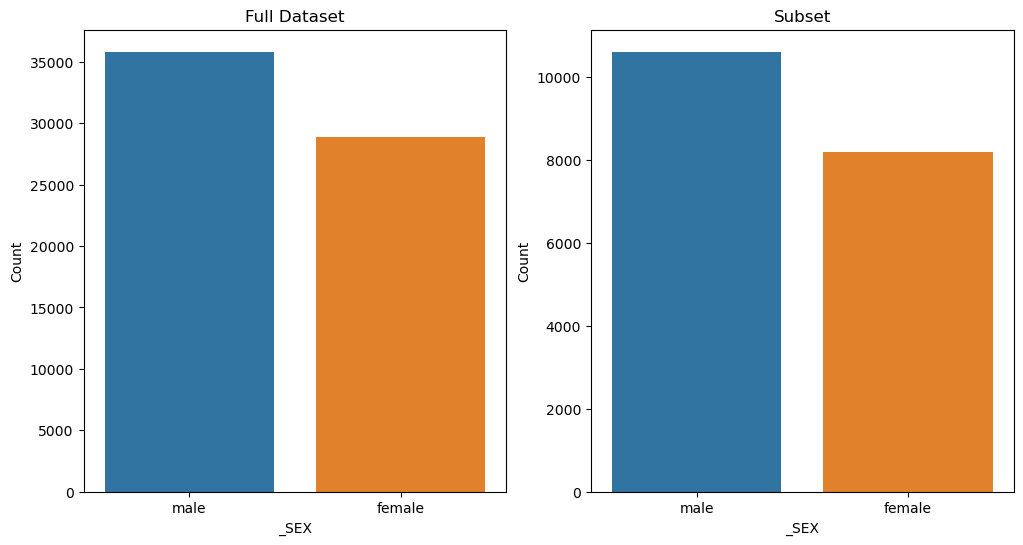

In [45]:
#compare the distribution of _SEX in the full dataset and the subset

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df2, x='_SEX', ax=axs[0])
axs[0].set_title('Full Dataset')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(['male', 'female'])

sns.countplot(data=df2_subset, x='_SEX', ax=axs[1])
axs[1].set_title('Subset')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(['male', 'female'])

The above visualizations confirm that age, sex, and race/ethnicity distributions of the full original data and ACE subset are closely similar. The subset of total data (n = 64,675) for which ACE variables are present (n = 18,793) appear generally similar across demographic categories. 

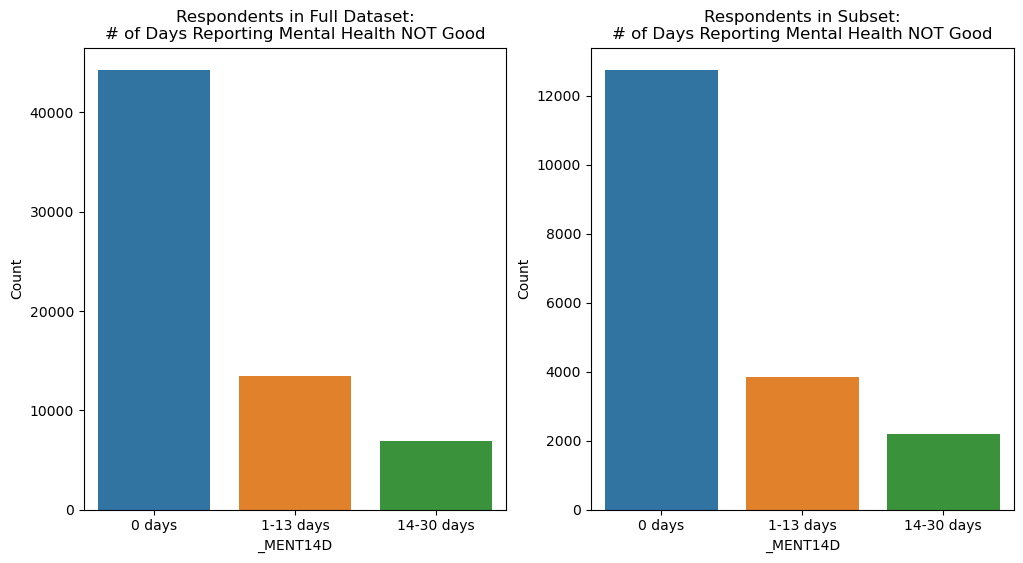

In [46]:
#compare the distribution of _MENT14D in the full dataset and the subset
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df2, x='_MENT14D', ax=axs[0])
axs[0].set_title('Respondents in Full Dataset:\n# of Days Reporting Mental Health NOT Good')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(['0 days','1-13 days','14-30 days'])

sns.countplot(data=df2_subset, x='_MENT14D', ax=axs[1])
axs[1].set_title('Respondents in Subset:\n# of Days Reporting Mental Health NOT Good')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(['0 days','1-13 days','14-30 days'])

plt.show()

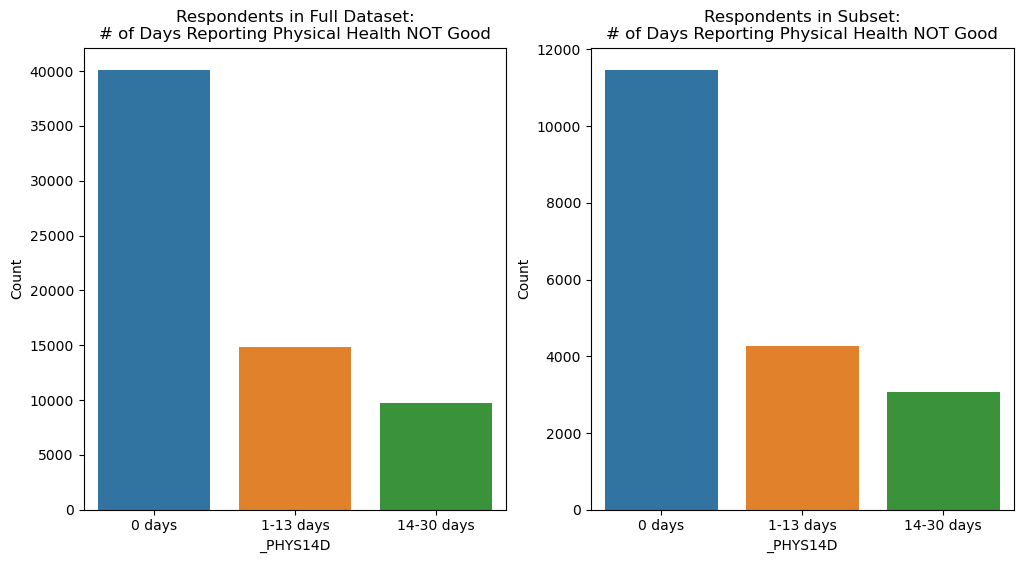

In [47]:
#compare the distribution of _PHYS14D in the full dataset and the subset
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df2, x='_PHYS14D', ax=axs[0])
axs[0].set_title('Respondents in Full Dataset:\n# of Days Reporting Physical Health NOT Good')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(['0 days','1-13 days','14-30 days'])

sns.countplot(data=df2_subset, x='_PHYS14D', ax=axs[1])
axs[1].set_title('Respondents in Subset:\n# of Days Reporting Physical Health NOT Good')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(['0 days','1-13 days','14-30 days'])

plt.show()

Proportions of respondents across whole data and subset reporting many days where physical or mental health not good seem roughly similar, but a greater proportion of the data subset are reporting many unwell days. 

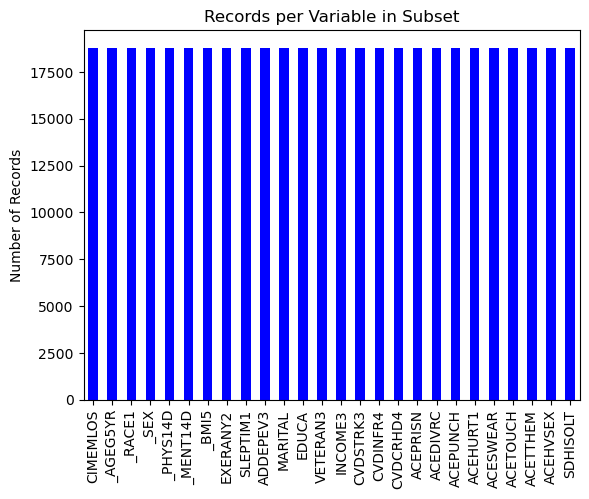

In [64]:
#show number of records for each variable in subset
df2_subset.count().plot(kind='bar', color='blue')
plt.title('Records per Variable in Subset')
plt.ylabel('Number of Records')
plt.show()

In [16]:
#show distribution of values in subset for every variable
for col in df2_subset.columns:
    if col not in ['CIMEMLOS', '_AGEG5YR', '_BMI5']:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df2_subset, x=col)
        plt.title(f'Distribution of {col}')
        plt.ylabel('Count')
        
        # Change x-axis labels for _SEX column
        if col == '_SEX':
            plt.xticks(ticks=[0, 1], labels=['male', 'female'])
        if col == '_RACE1':
            plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['white','black','AI/AN','Asian','NHOPI','Multiracial','Hispanic'])        
        if col == '_MENT14D':
            plt.xticks(ticks=[0, 1, 2], labels=['0 days','1-13 days','14-30 days'])
        if col == '_PHYS14D':
            plt.xticks(ticks=[0, 1, 2], labels=['0 days','1-13 days','14-30 days'])
        if col == 'CVDCRHD4':
            plt.xticks(ticks=[0, 1], labels=['no','yes'])
        if col == 'ACESWEAR':
            plt.xticks(ticks=[0, 1, 2], labels=['no','yes','unknown/refused'])
        if col == 'ACETOUCH':
            plt.xticks(ticks=[0, 1, 2], labels=['no','yes','unknown/refused'])
        if col == 'ACETTHEM':
            plt.xticks(ticks=[0, 1, 2], labels=['no','yes','unknown/refused'])
        if col == 'ACEHVSEX':
            plt.xticks(ticks=[0, 1, 2], labels=['no','yes','unknown/refused'])
        
        plt.show()


NameError: name 'df2_subset' is not defined

//**--MICRO PROJECT 3, ANA 500, WEEK 3--**\\

To satisfy this week's assignment requirements, I first used the continuous variable _BMI5 for my multiple linear regression output. Then, I switched over to logistic regression to tackle my research question, because my outcome variable is categorical. 

In [1]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from dmba import regressionSummary
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#load data from Micro Project 1
df_cohort1 = pd.read_csv("brfss2022_clean.csv")

#check data load
df_cohort1.head()

#create cf_cohort2 by removing records with missing values
df_cohort2 = df_cohort1.dropna()

#drop ACE variables from cohort 1)
df_cohort1 = df_cohort1.drop(columns=['ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX'])

#print shape of df_cohort1 and df_cohort2
print("cohort 1: ",df_cohort1.shape)
print("cohort 2: ",df_cohort2.shape)

cohort 1:  (64675, 18)
cohort 2:  (18793, 26)


In [51]:
### Demonstration of MLR modeling on continuous variable _BMI5 in dataset (1/3)

##run multiple linear regression for cohort 1 (excluding ACE values, n = 64,675) with the 
##outcome variable CIMEMLOS (worsening memory and/or confusion) and provided predictor variables

predictors = ['CIMEMLOS', 'ADDEPEV3', '_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'MARITAL', 'EDUCA', 'VETERAN3', 'INCOME3', 'CVDSTRK3', 
       'CVDINFR4', 'CVDCRHD4', 'SDHISOLT']

outcome = '_BMI5'

#standardize continuous variable (only _BMI5)
scaler = StandardScaler()
df_cohort1['_BMI5'] = scaler.fit_transform(df_cohort1[['_BMI5']])

#partition data
X = pd.get_dummies(df_cohort1[predictors], drop_first=True)
y = df_cohort1[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

cohort1_lm = LinearRegression()
cohort1_lm.fit(train_X, train_y)

#print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': cohort1_lm.coef_}))

#print preformance measures (training data)
cohort1_lm_pred = cohort1_lm.predict(valid_X)
regressionSummary(train_y, cohort1_lm.predict(train_X))

   Predictor  coefficient
0   CIMEMLOS    -0.047121
1   ADDEPEV3     0.180235
2   _AGEG5YR    -0.068979
3     _RACE1    -0.001860
4       _SEX     0.085744
5   _PHYS14D     0.099921
6   _MENT14D    -0.012070
7   EXERANY2    -0.323031
8   SLEPTIM1    -0.017760
9    MARITAL     0.015463
10     EDUCA    -0.095388
11  VETERAN3    -0.006662
12   INCOME3    -0.001056
13  CVDSTRK3    -0.006822
14  CVDINFR4     0.023446
15  CVDCRHD4     0.115811
16  SDHISOLT     0.006253

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9616
            Mean Absolute Error (MAE) : 0.7071
          Mean Percentage Error (MPE) : 391.1987
Mean Absolute Percentage Error (MAPE) : 3118.2776


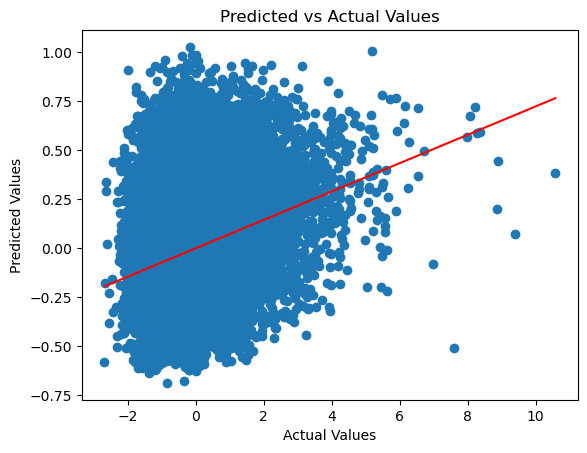

In [52]:
### Demonstration of MLR modeling on continuous variable _BMI5 in dataset (3/3)

#plot of actual vs predicted values with red best-fit line
plt.scatter(valid_y, cohort1_lm_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot(np.unique(valid_y), np.poly1d(np.polyfit(valid_y, cohort1_lm_pred, 1))(np.unique(valid_y)), color='red')
plt.show()

The model appears to perform reasonably well across both the training and validation datasets. RMSE (5.96) and MAE (4.34) values are similar between datasets, which points to a lack of overfitting. A very low Mean Error of 0.01 indicates no significant bias model prediction.

However, the presence of high outliers at the higher range of the scaled _BMI5 distribution signals potential issues and should be tackled prior to any downstream application of this model.

The above shows how a MLR model could be programmed to consider a continuous outcome variable. 

However, since my research question pertains to a categorical outcome variable, I used logistic regression instead and generated a classification report, because that is more appropriate.

Also, as indicated above, I considered two separate cohorts. Cohort 1 (n = 64,675) looks at predictor variables excluding those of adverse childhood experiences (ACE), because ACE variables are only available for a limited number of respondent records (n = 18,793). Cohort 2 analysis adds in these ACE variables to the model and considers only the 18,793 respondent records for which all predictors, including ACE data, are available. 

In [53]:
df_cohort1.columns

Index(['CIMEMLOS', '_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       '_BMI5', 'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'SDHISOLT'],
      dtype='object')

In [54]:
##COHORT 1 (n = 64,675) : MULTIPLE LOGISTIC REGRESSION

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA','VETERAN3',
       'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'SDHISOLT']

#partition data
X = pd.get_dummies(df_cohort1[predictors_subset], drop_first=True)
y = df_cohort1[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#fit the logistic regression model
cohort1_lr = LogisticRegression(max_iter=1000)
cohort1_lr.fit(train_X, train_y)

#predict training data
train_pred = cohort1_lr.predict(train_X)

#print performance measures
print("Training Data Performance:")
print(confusion_matrix(train_y, train_pred))
print(classification_report(train_y, train_pred))
print("Accuracy:", accuracy_score(train_y, train_pred))

#predict on validation data
valid_pred = cohort1_lr.predict(valid_X)

#print performance measures for validation data
print("Validation Data Performance:")
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))
print("Accuracy:", accuracy_score(valid_y, valid_pred))

Training Data Performance:
[[34318   299]
 [ 3844   344]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     34617
         1.0       0.53      0.08      0.14      4188

    accuracy                           0.89     38805
   macro avg       0.72      0.54      0.54     38805
weighted avg       0.86      0.89      0.86     38805

Accuracy: 0.8932354078082722
Validation Data Performance:
[[22854   201]
 [ 2621   194]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     23055
         1.0       0.49      0.07      0.12      2815

    accuracy                           0.89     25870
   macro avg       0.69      0.53      0.53     25870
weighted avg       0.85      0.89      0.85     25870

Accuracy: 0.8909161190568226


This logistic regression model achieved a high accuracy on the training data (89.3%) and performed about the same on the validation data (89.1%), indicating that the model is not overfitting. The model's precision (90%) and recall (99%) on the negative class (lack of memory problems and/or confusion) outperforms its prediction of the positive class (presence of memory problems and/or confusion; precision = 0.49, recall = 0.07). This discrepancy suggests the model may not generalize well. Overall weighted scores indicate a class imbalance.

After setting the class_weight parameter to 'balanced' (to balance the classes), I reran the model and generated visualizations of the ROC and resultant confusion matrix on the class-balanced dataset.

Validation Data Performance:
[[17268  5787]
 [ 1029  1786]]
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84     23055
         1.0       0.24      0.63      0.34      2815

    accuracy                           0.74     25870
   macro avg       0.59      0.69      0.59     25870
weighted avg       0.87      0.74      0.78     25870

Accuracy: 0.7365287978353305


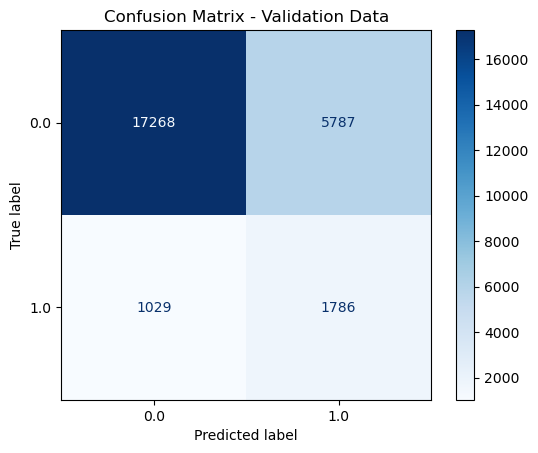

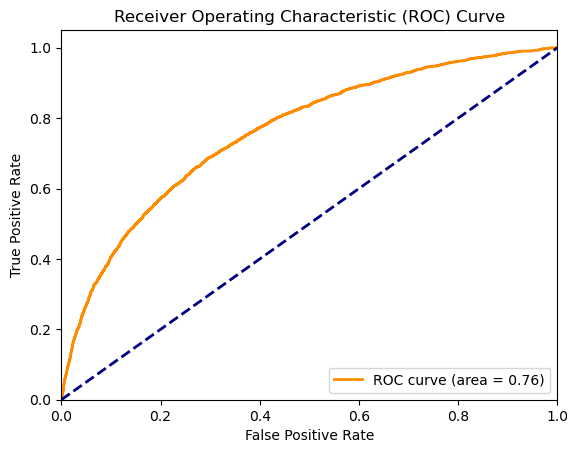

In [55]:
#create a logistic regression model with balanced class weights
cohort1_lr2 = LogisticRegression(max_iter=1000, class_weight='balanced')
cohort1_lr2.fit(train_X, train_y)

#predict on validation data
valid_pred = cohort1_lr2.predict(valid_X)

#print performance measures for validation data
print("Validation Data Performance:")
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))
print("Accuracy:", accuracy_score(valid_y, valid_pred))

#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cohort1_lr2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

#create ROC curve for validation data
fpr, tpr, _ = roc_curve(valid_y, cohort1_lr2.predict_proba(valid_X)[:, 1])
roc_auc = roc_auc_score(valid_y, cohort1_lr2.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

This class balancing approached significantly improved the recall on the positive class of my model, from 0.07 initial to 0.63. Accuracy decreased from 89.1% to 73.7%, but the utility of the model was greatly improved. 

In [56]:
df_cohort2.columns

Index(['CIMEMLOS', '_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       '_BMI5', 'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX', 'SDHISOLT'],
      dtype='object')

In [57]:
##COHORT 2 (n = 18,793) : MULTIPLE LOGISTIC REGRESSION

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA', 'SDHISOLT',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX']

#partition data
X = pd.get_dummies(df_cohort2[predictors_subset], drop_first=True)
y = df_cohort2[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#fit the logistic regression model with 'balanced' class_weight
cohort2_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
cohort2_lr.fit(train_X, train_y)

#predict training data
train_pred = cohort2_lr.predict(train_X)

#print performance measures
print("Training Data Performance:")
print(confusion_matrix(train_y, train_pred))
print(classification_report(train_y, train_pred))
print("Accuracy:", accuracy_score(train_y, train_pred))

#predict on validation data
valid_pred = cohort2_lr.predict(valid_X)

#print performance measures for validation data
print("Validation Data Performance:")
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))
print("Accuracy:", accuracy_score(valid_y, valid_pred))

Training Data Performance:
[[7444 2564]
 [ 447  820]]
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     10008
         1.0       0.24      0.65      0.35      1267

    accuracy                           0.73     11275
   macro avg       0.59      0.70      0.59     11275
weighted avg       0.86      0.73      0.78     11275

Accuracy: 0.7329490022172949
Validation Data Performance:
[[4960 1677]
 [ 332  549]]
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.83      6637
         1.0       0.25      0.62      0.35       881

    accuracy                           0.73      7518
   macro avg       0.59      0.69      0.59      7518
weighted avg       0.86      0.73      0.78      7518

Accuracy: 0.7327746741154563


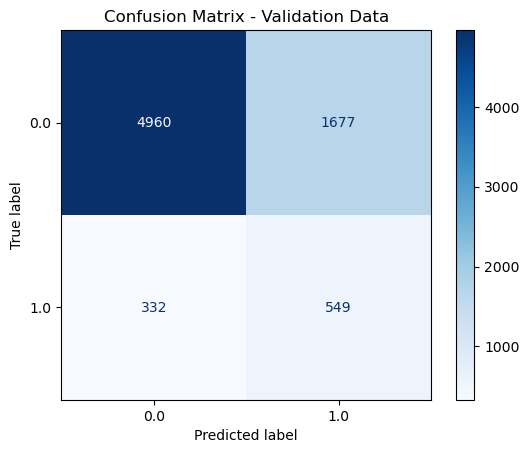

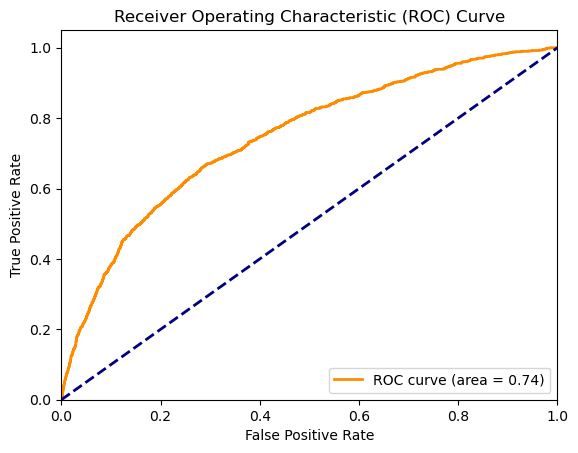

In [58]:
#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cohort2_lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

#create ROC curve for validation data
fpr, tpr, _ = roc_curve(valid_y, cohort2_lr.predict_proba(valid_X)[:, 1])
roc_auc = roc_auc_score(valid_y, cohort2_lr.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Support Vector Machine Models (Cohort 1 & Cohort 2)

In [60]:
from sklearn.svm import SVC

##COHORT 1 (n = 64,675) : SUPPORT VECTOR MACHINE

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA','VETERAN3',
       'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'SDHISOLT']

#partition data
X = pd.get_dummies(df_cohort1[predictors_subset], drop_first=True)
y = df_cohort1[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#create an SVM model with balanced class weights
cohort1_svm = SVC(kernel='linear', class_weight='balanced', probability=True)
cohort1_svm.fit(train_X, train_y)

#predict on validation data
valid_pred = cohort1_svm.predict(valid_X)

#print performance metrics
print("Validation Data Performance:")
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))
print("Accuracy:", accuracy_score(valid_y, valid_pred))


Validation Data Performance:
[[17925  5130]
 [ 1138  1677]]
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     23055
         1.0       0.25      0.60      0.35      2815

    accuracy                           0.76     25870
   macro avg       0.59      0.69      0.60     25870
weighted avg       0.86      0.76      0.80     25870

Accuracy: 0.7577116350985698


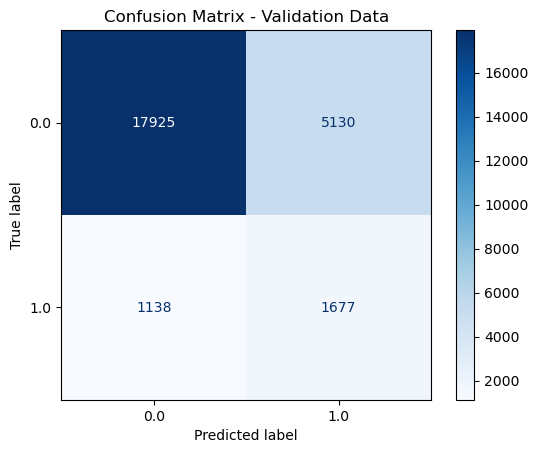

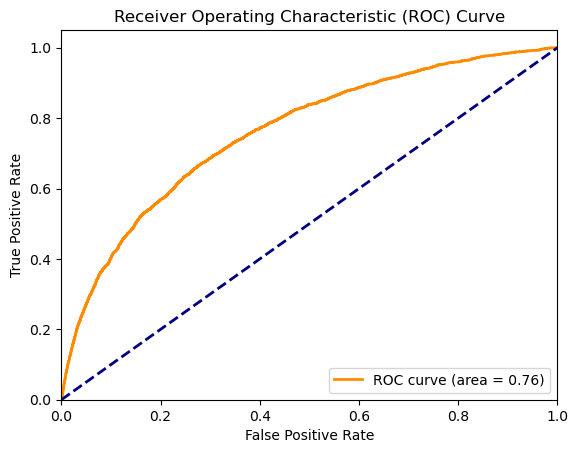

In [61]:
#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cohort1_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

#create ROC curve for validation data
fpr, tpr, _ = roc_curve(valid_y, cohort1_svm.predict_proba(valid_X)[:, 1])
roc_auc = roc_auc_score(valid_y, cohort1_svm.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [62]:
##COHORT 2 (n = 18,793) : SUPPORT VECTOR MACHINE

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA', 'SDHISOLT',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX']

#partition data
X = pd.get_dummies(df_cohort2[predictors_subset], drop_first=True)
y = df_cohort2[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#create an SVM model with balanced class weights
cohort2_svm = SVC(kernel='linear', class_weight='balanced', probability=True)
cohort2_svm.fit(train_X, train_y)

#predict on validation data
valid_pred = cohort2_svm.predict(valid_X)

#print performance metrics
print("Validation Data Performance:")
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))
print("Accuracy:", accuracy_score(valid_y, valid_pred))


Validation Data Performance:
[[5093 1544]
 [ 355  526]]
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84      6637
         1.0       0.25      0.60      0.36       881

    accuracy                           0.75      7518
   macro avg       0.59      0.68      0.60      7518
weighted avg       0.86      0.75      0.79      7518

Accuracy: 0.7474062250598563


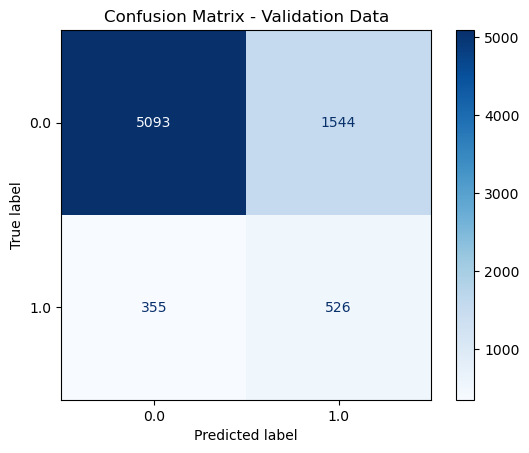

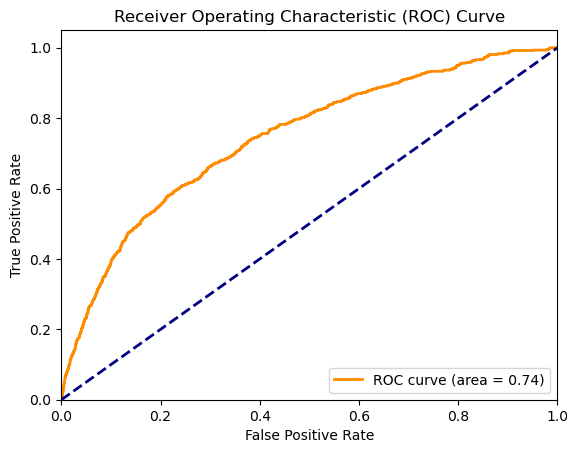

In [63]:
#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cohort2_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

#create ROC curve for validation data
fpr, tpr, _ = roc_curve(valid_y, cohort2_svm.predict_proba(valid_X)[:, 1])
roc_auc = roc_auc_score(valid_y, cohort2_svm.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

//**--MICRO PROJECT 4, ANA 500, WEEK 4--**\

In this final project, an additional 3 machine learning techniques will be run on each of my 2 cohorts: 
    1) Random forest model,
    2) Neural network model with Keras & TensorFlow

As a reminder, Cohort 1 (n = 64,675) contains data for all variables except for adverse childhood experience (ACE), 
and Cohort 2 (n = 18,793) is a subsample for which ACE variables have been included. So far, including these ACE variables has not improved model performance for either multiple logistic regression or support vector machine approaches.

NOTE: Scaling is not necessary, as all of my variables are categorical.

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93     23055
         1.0       0.25      0.07      0.10      2815

    accuracy                           0.88     25870
   macro avg       0.57      0.52      0.52     25870
weighted avg       0.83      0.88      0.84     25870



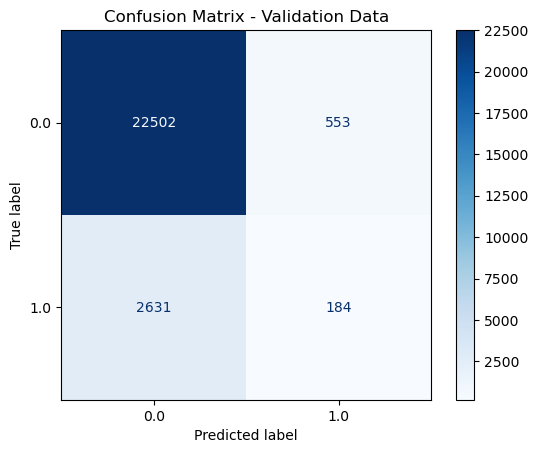

In [68]:
## COHORT 1 (n = 64,675) : Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA','VETERAN3',
       'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'SDHISOLT']

#partition data
X = pd.get_dummies(df_cohort1[predictors_subset], drop_first=True)
y = df_cohort1[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#initialize & train random forest classifier
c1_rfm = RandomForestClassifier(n_estimators=100, class_weight='balanced')
c1_rfm.fit(train_X, train_y)

#use model to predict values
c1_rfm_y_pred = c1_rfm.predict(valid_X)

#print classification report
print(classification_report(valid_y, c1_rfm_y_pred))

#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, c1_rfm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cohort2_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

In [9]:
## COHORT 1 (n = 64,675) : Neural network model with Keras & TensorFlow

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Define the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
                     'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA',
                     'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'SDHISOLT']

# Partition data
X = pd.get_dummies(df_cohort1[predictors_subset], drop_first=True)
y = df_cohort1[outcome]

# Convert target variable to categorical
y = to_categorical(y)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(valid_X, valid_y))

Epoch 1/50


C:\Users\unkno\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3881/3881 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8910 - loss: 0.3378 - val_accuracy: 0.8920 - val_loss: 0.3095
Epoch 2/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8942 - loss: 0.2992 - val_accuracy: 0.8915 - val_loss: 0.3078
Epoch 3/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8917 - loss: 0.3006 - val_accuracy: 0.8924 - val_loss: 0.3057
Epoch 4/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8944 - loss: 0.2977 - val_accuracy: 0.8913 - val_loss: 0.2993
Epoch 5/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8877 - loss: 0.3056 - val_accuracy: 0.8910 - val_loss: 0.2997
Epoch 6/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8939 - loss: 0.2940 - val_accuracy: 0.8919 - val_loss: 0.2995
Epoch 7/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8964 - loss: 0.2925 - val_accuracy: 0.8919 - val_loss: 0.2991
Epoch 8/50
3881/3881 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8907 - loss: 0.3017 - val_accurac

NameError: name 'np' is not defined

809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     23055
           1       0.47      0.07      0.13      2815

    accuracy                           0.89     25870
   macro avg       0.68      0.53      0.53     25870
weighted avg       0.85      0.89      0.85     25870



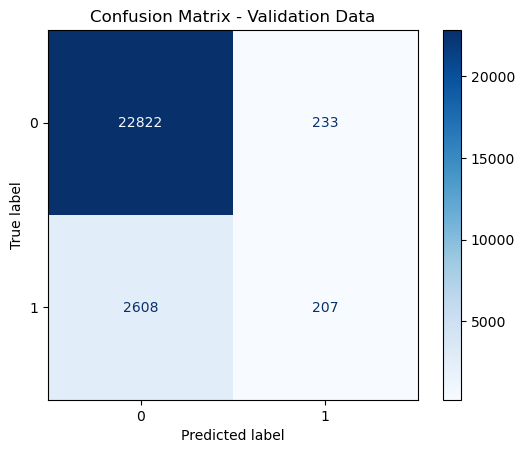

In [12]:
#use model to predict values
c1_keras_y_pred = np.argmax(model.predict(valid_X), axis=-1)
valid_y_true = np.argmax(valid_y, axis=-1)

#print classification report
print(classification_report(valid_y_true, c1_keras_y_pred))

# Create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y_true, c1_keras_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(valid_y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      6637
         1.0       0.33      0.03      0.06       881

    accuracy                           0.88      7518
   macro avg       0.61      0.51      0.50      7518
weighted avg       0.82      0.88      0.83      7518



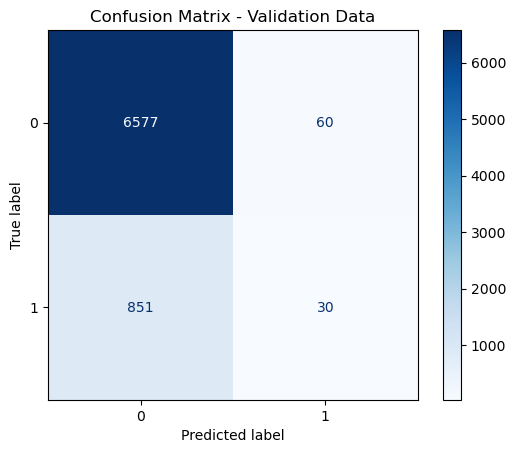

In [21]:
## COHORT 2 (n = 18,793) : Random Forest Model

#defined the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA', 'SDHISOLT',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX']

#partition data
X = pd.get_dummies(df_cohort2[predictors_subset], drop_first=True)
y = df_cohort2[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#initialize & train random forest classifier
c2_rfm = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
c2_rfm.fit(train_X, train_y)

#use model to predict values
c2_rfm_y_pred = c2_rfm.predict(valid_X)

#print classification report
print(classification_report(valid_y, c2_rfm_y_pred))

#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y, c2_rfm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

In [22]:
## COHORT 2 (n = 18,793) : Neural network model with Keras & TensorFlow

# Define the outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
       'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA', 'SDHISOLT',
       'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX']

# Partition data
X = pd.get_dummies(df_cohort2[predictors_subset], drop_first=True)
y = df_cohort2[outcome]

# Convert target variable to categorical
y = to_categorical(y)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(valid_X, valid_y))

Epoch 1/50


C:\Users\unkno\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1128/1128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8750 - loss: 0.3767 - val_accuracy: 0.8794 - val_loss: 0.3289
Epoch 2/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8882 - loss: 0.3165 - val_accuracy: 0.8820 - val_loss: 0.3356
Epoch 3/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8835 - loss: 0.3195 - val_accuracy: 0.8836 - val_loss: 0.3396
Epoch 4/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8849 - loss: 0.3199 - val_accuracy: 0.8815 - val_loss: 0.3295
Epoch 5/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8867 - loss: 0.3144 - val_accuracy: 0.8824 - val_loss: 0.3357
Epoch 6/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8890 - loss: 0.3081 - val_accuracy: 0.8806 - val_loss: 0.3318
Epoch 7/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8917 - loss: 0.3024 - val_accuracy: 0.8827 - val_loss: 0.3229
Epoch 8/50
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8905 - loss: 0.3051 - val_accurac

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6637
           1       0.35      0.12      0.18       881

    accuracy                           0.87      7518
   macro avg       0.62      0.55      0.56      7518
weighted avg       0.83      0.87      0.84      7518



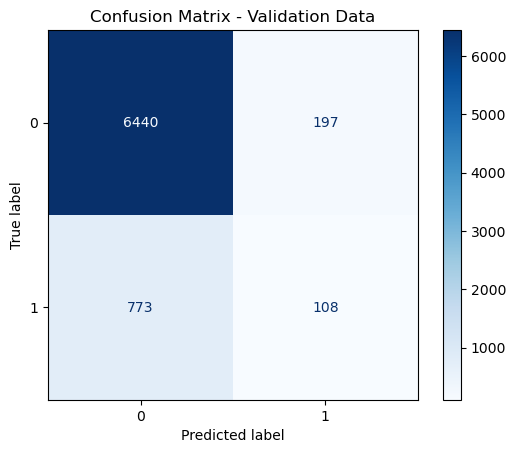

In [23]:
#use model to predict values
c1_keras_y_pred = np.argmax(model.predict(valid_X), axis=-1)
valid_y_true = np.argmax(valid_y, axis=-1)

#print classification report
print(classification_report(valid_y_true, c1_keras_y_pred))

# Create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y_true, c1_keras_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(valid_y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

The Keras and Tensorflow model is performing well predicting Class 0, with high precision (0.89) and recall (0.97), explaining the high F1-score of 0.93. However, the model struggles with predicting Class 1 (i.e. precision = 0.35; recall = 0.13), yielding a low overall F1-score of 0.18. To attempt improvement on the model's performance on Class 1, I incorporated class balancing, looked at adjusting class weights, and additional model tuning.

Epoch 1/100


C:\Users\unkno\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5247 - loss: 1.8294 - val_accuracy: 0.6854 - val_loss: 0.6737
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5394 - loss: 0.8401 - val_accuracy: 0.7787 - val_loss: 0.6591
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6572 - loss: 0.6906 - val_accuracy: 0.7712 - val_loss: 0.6378
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6895 - loss: 0.6657 - val_accuracy: 0.7672 - val_loss: 0.6275
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7013 - loss: 0.6315 - val_accuracy: 0.7595 - val_loss: 0.6267
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7073 - loss: 0.6377 - val_accuracy: 0.7953 - val_loss: 0.5708
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7399 - loss: 0.6248 - val_accuracy: 0.7543 - val_loss: 0.6056
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7230 - loss: 0.6250 - val_accuracy: 0.7563

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      6637
           1       0.26      0.57      0.36       881

    accuracy                           0.76      7518
   macro avg       0.60      0.68      0.61      7518
weighted avg       0.85      0.76      0.80      7518



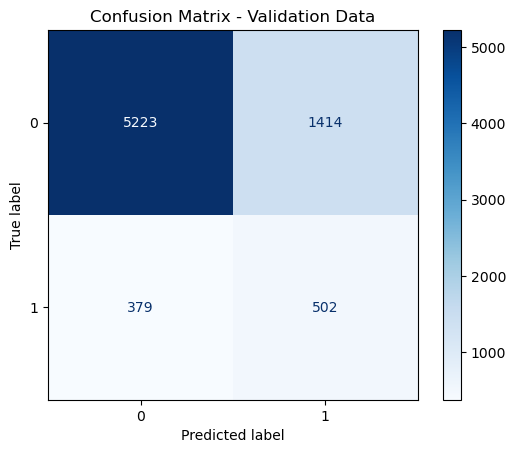

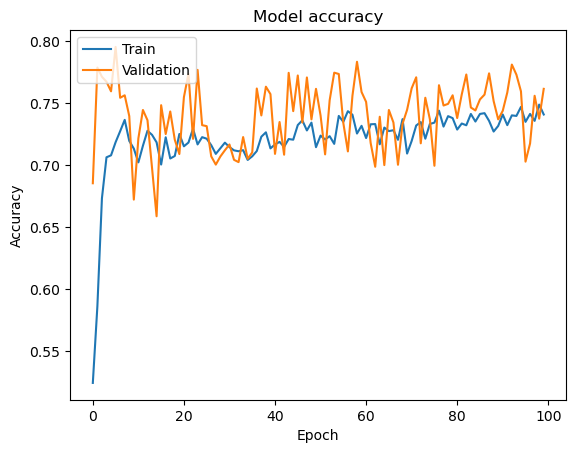

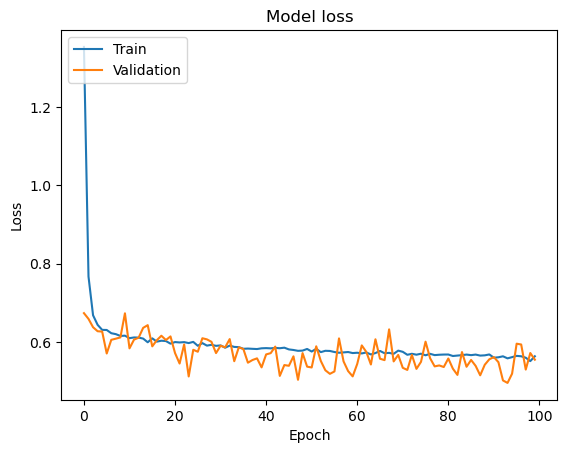

In [31]:
## COHORT 2 (n = 18,793) : Neural network model with Keras & TensorFlow (with class balancing, 
## adjusted class weights, and model tuning)

from sklearn.utils import class_weight
from tensorflow.keras.layers import Dropout

#define outcome variable and predictors
outcome = 'CIMEMLOS'
predictors_subset = ['_AGEG5YR', '_RACE1', '_SEX', '_PHYS14D', '_MENT14D',
                     'EXERANY2', 'SLEPTIM1', 'ADDEPEV3', 'MARITAL', 'EDUCA', 'SDHISOLT',
                     'VETERAN3', 'INCOME3', 'CVDSTRK3', 'CVDINFR4', 'CVDCRHD4', 'ACEPRISN',
                     'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
                     'ACEHVSEX']

#partition data
X = pd.get_dummies(df_cohort2[predictors_subset], drop_first=True)
y = df_cohort2[outcome]

#ensure target variable is categorical
if len(y.shape) == 1:
    y = to_categorical(y)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(train_y, axis=1)), y=np.argmax(train_y, axis=1))
class_weights_dict = dict(enumerate(class_weights))

#initialize and build neural network model
model = Sequential()
model.add(Dense(128, input_dim=train_X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_y.shape[1], activation='softmax'))

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model with class weights
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(valid_X, valid_y), class_weight=class_weights_dict)

#evaluate model
c1_keras_y_pred = np.argmax(model.predict(valid_X), axis=-1)
valid_y_true = np.argmax(valid_y, axis=-1)

#print classification report
print(classification_report(valid_y_true, c1_keras_y_pred))

#create confusion matrix for validation data
conf_matrix = confusion_matrix(valid_y_true, c1_keras_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(valid_y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

#plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Class balancing, There was a significant improvement after class balancing, adjusting class weights, and tuning the model. While the overall accuracy decrease from 0.87 to 0.76, Class 1 recall improved from 0.12 to 0.57, doubling its F1-Score (0.18 to 0.36). Since recall for minority classes is especially important in imbalanced datasets, the trade-off was worth it. 

In [34]:
print("All models compared in Final PPT Report!")

All models compared in Final PPT Report!
